<h1 style="background-color:rgb(67, 194, 50); text-align: center"> PredFinAI – Corporate Bankruptcy Prediction Using Machine Learning Models</h1>

**Objective**
This project aims to build a clean and analyzable dataset of corporate financial metrics sourced from the SEC EDGAR database. This data will later serve as the foundation for predictive models capable of estimating the probability of bankruptcy, financial distress, or credit defaults. In this phase, we focus on ETL (Extract, Transform, Load) processes and EDA (Exploratory Data Analysis).

**Data Source**
We use publicly available data from the SEC EDGAR portal, specifically the Financial Statement and Notes Datasets: https://www.sec.gov/data-research/sec-markets-data/financial-statement-notes-data-sets.

These datasets include structured financial statements and explanatory notes submitted by publicly traded U.S. companies, typically as part of annual reports (10-K forms). The data is extracted directly from XBRL filings and organized into machine-readable tables.

🔹 Documentation of file structure, scope, and field definitions is provided in the official technical specification: https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/2025_02_notes.zip

These resources contain:

Company identifiers (CIK, form type, filing date)

Detailed financial metrics, including:

Assets and liabilities

Revenue, income, and earnings per share

Cash flow statements

Liquidity, solvency, and profitability ratios

Footnotes and textual metadata that may indicate risk, uncertainty, or early signals of financial distress

The data is structured across several normalized tables such as sub.txt, num.txt, tag.txt, etc., which can be joined using common keys.

This comprehensive dataset serves as the foundation for our ETL pipeline, feature engineering, and eventual machine learning model for bankruptcy prediction.

In [861]:
# %conda init
# %conda deactivate
# %conda activate credit-analysis-dashboard
# %conda install numpy pandas requests bs4 tqdm openai matplotlib seaborn 
# %conda install -c conda-forge ratelimit lxml statsmodels 
# %conda install conda-forge::nltk

In [862]:
import numpy as np # linear algebra, arithmentic calculations
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [863]:
# !pip install scikit-learn


<h2 style="background-color: #ffd5cd; text-align: center">ELT-Extract</h2>

In [864]:
# import requests
# from zipfile import ZipFile, BadZipFile
# from datetime import datetime

# # Base URL for the reports
# base_url = "https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/{}_02_notes.zip"

# # Local directory to save the files
# local_dir = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/"

# # Current year
# current_year = datetime.now().year

# # Iterate over the last 10 years
# for year in range(current_year - 10, current_year):
#     url = base_url.format(year)
#     local_filename = f"{local_dir}{year}_02_notes.zip"

#     # Download the file
#     headers = {
#         "User-Agent": "NataliaStekolnikova-FinRiskApp/1.0 (natalia.a.stekolnikova@gmail.com)",
#         "Accept-Encoding": "gzip, deflate",
#         "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
#         "Connection": "keep-alive",
#         "Host": "www.sec.gov",  # Add the Host header
#         "Referer": "https://www.sec.gov/",  # Add a Referer header
#         "From": "natalia.a.stekolnikova@gmail.com"  # Replace with your email address
#     }
#     response = requests.get(url, headers=headers, stream=True)
#     if response.status_code == 200:
#         with open(local_filename, "wb") as f:
#             for chunk in response.iter_content(chunk_size=8192):
#                 f.write(chunk)
#         print(f"Downloaded: {local_filename}")

#         # Extract the zip
#         try:
#             with ZipFile(local_filename, 'r') as zip_ref:
#                 extract_path = f"{local_dir}{year}_02_notes/"
#                 zip_ref.extractall(extract_path)
#                 print(f"Extracted to {extract_path}")
#         except BadZipFile:
#             print(f"Error: The downloaded file for {year} is not a valid ZIP file.")
#     else:
#         print(f"Failed to download file for {year}. Status code: {response.status_code}")

<h2 style="background-color: #ffd5cd; text-align: center">ELT-Load</h2>

### Overview: SEC Financial Statement Data — File Utility for Predictive Modeling

| File        | Description                                                                                      | Use for Modeling                                                               |
|-------------|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| `num.tsv`   | Contains actual **financial values** (e.g., revenue, net income, assets, liabilities).           | **Core dataset** for training features and targets.                           |
| `sub.tsv`   | Metadata: company ID (CIK), name, SIC, reporting period, form type (10-K, 10-Q), etc.            | Used to **filter and contextualize** `num.tsv` data.                          |
| `tag.tsv`   | Dictionary of all tags: names, labels, definitions, and whether standard or custom.              | Helps map tags to consistent financial concepts (e.g., revenue, income, etc). |
| `dim.tsv`   | Dimension info (e.g., data by business segments, geographic regions).                            | Used to **filter for consolidated data** or include segment-level details.    |
| `pre.tsv`   | Shows how line items appear in statements (e.g., order, section, label).                         | Useful for **resolving ambiguous/custom tags**.                               |
| `cal.tsv`   | Arithmetic relationships (e.g., which tags sum to totals).                                        | Optional: **reconstruct or validate missing/aggregated values**.              |
| `ren.tsv`   | Report rendering structure for display in SEC viewer.                                            | Not relevant for prediction modeling.                                       |
| `txt.tsv`   | Text blocks (e.g., accounting policies, risk notes, disclosures).                                 | Only useful for **NLP-based analysis**, not for numeric modeling.          |


In [ ]:
# # Define the years of interest
# years_of_interest = [2025]

# # Define the input directory template
# DATA_INPUT_DIR_TEMPLATE = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/{}_02_notes/"

# # List of file names to load
# file_names = ["sub", "num", "tag", "cal", "dim", "pre", "ren", "txt"]

# # Initialize a dictionary to store DataFrames for each year
# dataframes_by_year = {}

# # Iterate over the years of interest
# for year in years_of_interest:
#     # Format the input directory for the current year
#     year_input_dir = DATA_INPUT_DIR_TEMPLATE.format(year)
    
#     if os.path.exists(year_input_dir):
#         # Load each .tsv file into a DataFrame and store it in the dictionary
#         dataframes_by_year[year] = {
#             file_name: pd.read_csv(
#                 os.path.join(year_input_dir, f"{file_name}.tsv"), 
#                 sep='\t', 
#                 low_memory=False
#             )
#             for file_name in file_names
#         }
#         print(f"Data for year {year} loaded successfully from {year_input_dir}")
#     else:
#         print(f"Directory for year {year} does not exist: {year_input_dir}")

# # Concatenate data for each file type across all years
# file_dataframes = {
#     file_type: pd.concat(
#         [dataframes_by_year[year][file_type] for year in years_of_interest if year in dataframes_by_year],
#         ignore_index=True
#     )
#     for file_type in file_names
# }

# sub = file_dataframes['sub']
# num = file_dataframes['num']
# tag = file_dataframes['tag']
# cal = file_dataframes['cal']
# dim = file_dataframes['dim']
# pre = file_dataframes['pre']
# ren = file_dataframes['ren']
# txt = file_dataframes['txt']


Data for year 2025 loaded successfully from C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2025_02_notes/


In [ ]:
# df2025 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2025.csv")
# df2024 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2024.csv")
# df2022 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2022.csv")
# df2021 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2021.csv")

# # Combine all dataframes into one
# united_df = pd.concat([df2025, df2024, df2022, df2021], ignore_index=True)

# # Define the output file path
# output_file_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary.csv"

# # Export the united dataframe to a CSV file
# united_df.to_csv(output_file_path, index=False)

# print(f"Combined data exported successfully to {output_file_path}")
# # united_df[united_df['name'].str.contains('NVIDIA CORP', case=False, na=False)].head(10).transpose()

,957,3491,8217
adsh,0001045810-25-000023,0001045810-24-000029,0001045810-21-000010
cik,1045810,1045810,1045810
name,NVIDIA CORP,NVIDIA CORP,NVIDIA CORP
countryba,US,US,US
stprba,CA,CA,CA
cityba,SANTA CLARA,SANTA CLARA,SANTA CLARA
accepted,2025-02-26 16:49:00.0,2024-02-21 16:37:00.0,2021-02-26 17:03:00.0
form,10-K,10-K,10-K
period,20250131.0,20240131.0,20210131.0
fy,2024.0,2023.0,2020.0


<h2 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis (EDA)</h2>

In [867]:
sub.tail(5).transpose()

,8858,8859,8860,8861,8862
adsh,0002003881-25-000010,0002015845-25-000012,0002021938-25-000009,0002026448-25-000015,0002040266-25-000007
cik,2003881,2015845,2021938,2026448,1841666
name,"STIRLING HOTELS & RESORTS, INC.","EVERUS CONSTRUCTION GROUP, INC.",SUNRISE COMMUNICATIONS AG,PRINCIPAL CREDIT REAL ESTATE INCOME TRUST,APA CORP
sic,6798.0,1531.0,4841.0,6798.0,1311.0
countryba,US,US,CH,US,US
stprba,TX,ND,NaN,IA,TX
cityba,DALLAS,BISMARCK,"OPFIKON, ZURICH",DES MOINES,HOUSTON
zipba,75254,58503,8152,50392,77042
bas1,14185 DALLAS PARKWAY,1730 BURNT BOAT DRIVE,THURGAUERSTRASSE 101B,711 HIGH STREET,2000 W SAM HOUSTON PKWY S
bas2,SUITE 1200,NaN,GLATTPARK,NaN,SUITE 200


In [868]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8863 entries, 0 to 8862
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         8863 non-null   object 
 1   cik          8863 non-null   int64  
 2   name         8863 non-null   object 
 3   sic          8511 non-null   float64
 4   countryba    8847 non-null   object 
 5   stprba       8392 non-null   object 
 6   cityba       8846 non-null   object 
 7   zipba        8844 non-null   object 
 8   bas1         8847 non-null   object 
 9   bas2         3731 non-null   object 
 10  baph         8858 non-null   object 
 11  countryma    8845 non-null   object 
 12  stprma       8407 non-null   object 
 13  cityma       8844 non-null   object 
 14  zipma        8840 non-null   object 
 15  mas1         8841 non-null   object 
 16  mas2         3716 non-null   object 
 17  countryinc   7998 non-null   object 
 18  stprinc      7463 non-null   object 
 19  ein   

In [869]:
sub.describe()

,cik,sic,ein,changed,wksi,fye,period,fy,filed,prevrpt,detail,nciks,pubfloatusd,floatdate,floatmems
count,8.863000e+03,8511.000000,8.863000e+03,5.314000e+03,8863.000000,8820.000000,8.775000e+03,2754.000000,8.863000e+03,8863.000000,8863.000000,8863.000000,1.969000e+03,1.969000e+03,1969.000000
mean,1.272957e+06,4868.293033,4.484226e+08,2.007402e+07,0.168340,1117.708617,2.024705e+07,2024.189542,2.025022e+07,0.001015,0.322239,1.032607,1.423564e+13,2.024047e+07,1.028949
std,5.512420e+05,1983.978220,3.326608e+08,1.204545e+05,0.374189,257.746957,4.894141e+03,0.438378,8.195186e+00,0.031852,0.467360,0.281767,4.006685e+14,1.621164e+03,0.387397
min,1.800000e+03,100.000000,0.000000e+00,1.960020e+07,0.000000,120.000000,2.005123e+07,2018.000000,2.025020e+07,0.000000,0.000000,1.000000,0.000000e+00,2.020063e+07,1.000000
25%,9.218250e+05,3011.000000,1.606322e+08,1.998085e+07,0.000000,1231.000000,2.024123e+07,2024.000000,2.025021e+07,0.000000,0.000000,1.000000,6.866000e+08,2.024063e+07,1.000000
50%,1.408710e+06,4911.000000,4.118836e+08,2.010061e+07,0.000000,1231.000000,2.025013e+07,2024.000000,2.025022e+07,0.000000,0.000000,1.000000,2.300000e+09,2.024063e+07,1.000000
75%,1.710340e+06,6770.000000,8.137016e+08,2.018013e+07,0.000000,1231.000000,2.025023e+07,2024.000000,2.025022e+07,0.000000,1.000000,1.000000,8.200000e+09,2.024063e+07,1.000000
max,2.052961e+06,8900.000000,1.000000e+09,2.024122e+07,1.000000,1231.000000,2.025043e+07,2025.000000,2.025023e+07,1.000000,1.000000,8.000000,1.612464e+16,2.025013e+07,16.000000


In [870]:
num.head(5).transpose()

,0,1,2,3,4
adsh,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012
tag,AccountsPayableCurrent,AccountsPayableCurrent,AccountsPayableCurrentAndNoncurrent,AccountsPayableCurrentAndNoncurrent,AccountsPayableOtherCurrentAndNoncurrent
version,us-gaap/2024,us-gaap/2024,us-gaap/2024,us-gaap/2024,us-gaap/2024
ddate,20231231,20241231,20231231,20241231,20231231
qtrs,0,0,0,0,0
uom,USD,USD,USD,USD,USD
dimh,0x00000000,0x00000000,0xad66b56c81571b0e9d4882f564c06174,0xad66b56c81571b0e9d4882f564c06174,0x00000000
iprx,0,0,0,0,0
value,2055000000.0,1990000000.0,363000000.0,476000000.0,363000000.0
footnote,NaN,NaN,NaN,NaN,NaN


In [871]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068718 entries, 0 to 5068717
Data columns (total 16 columns):
 #   Column    Dtype  
---  ------    -----  
 0   adsh      object 
 1   tag       object 
 2   version   object 
 3   ddate     int64  
 4   qtrs      int64  
 5   uom       object 
 6   dimh      object 
 7   iprx      int64  
 8   value     float64
 9   footnote  object 
 10  footlen   int64  
 11  dimn      int64  
 12  coreg     object 
 13  durp      float64
 14  datp      float64
 15  dcml      int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 618.7+ MB


In [872]:
num.describe()

,ddate,qtrs,iprx,value,footlen,dimn,durp,datp,dcml
count,5.068718e+06,5.068718e+06,5.068718e+06,5.003542e+06,5.068718e+06,5.068718e+06,5.068718e+06,5.068718e+06,5.068718e+06
mean,2.023428e+07,1.703154e+00,1.115010e-01,3.234493e+10,6.169426e-01,1.025176e+00,1.745428e-03,6.217154e-02,1.706087e+03
std,9.295193e+03,2.007115e+00,5.468252e-01,4.540973e+13,2.831589e+01,1.037582e+00,2.676112e-02,1.499532e+00,8.983557e+03
min,1.870123e+07,0.000000e+00,0.000000e+00,-2.412180e+13,0.000000e+00,0.000000e+00,-4.986300e-01,-1.500000e+01,-3.276800e+04
25%,2.023123e+07,0.000000e+00,0.000000e+00,1.310000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00
50%,2.024013e+07,0.000000e+00,0.000000e+00,4.097000e+06,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2.024123e+07,4.000000e+00,0.000000e+00,1.003970e+08,0.000000e+00,2.000000e+00,1.095891e-02,0.000000e+00,-3.000000e+00
max,2.074123e+07,1.360000e+02,5.900000e+01,1.000000e+17,2.679900e+04,9.000000e+00,4.986310e-01,1.500000e+01,3.276700e+04


In [873]:
tag.head(2)

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,A.5000EuroDenominatedNotesDue2033Member,0000059478-25-000067,1,1,member,NaN,NaN,.5000% Euro Denominated Notes Due 2033 [Member],.5000% Euro Denominated Notes Due 2033
1,A.C.SolucoesParaPiscinasLda.Member,0000945841-25-000032,1,1,member,NaN,NaN,"A.C. Solucoes para Piscinas, Lda. [Member]","A.C. Solucoes para Piscinas, Lda."


In [874]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514013 entries, 0 to 514012
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tag       514012 non-null  object
 1   version   514013 non-null  object
 2   custom    514013 non-null  int64 
 3   abstract  514013 non-null  int64 
 4   datatype  484269 non-null  object
 5   iord      277540 non-null  object
 6   crdr      153591 non-null  object
 7   tlabel    513950 non-null  object
 8   doc       477424 non-null  object
dtypes: int64(2), object(7)
memory usage: 35.3+ MB


In [875]:
tag.describe()

,custom,abstract
count,514013.000000,514013.000000
mean,0.957073,0.459994
std,0.202693,0.498397
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [876]:
# the tag dataset is NOT useful for our analysis

In [877]:
cal.head(2)

,adsh,grp,arc,negative,ptag,pversion,ctag,cversion
0,0001504461-25-000004,12,5,1,AccruedLiabilitiesCurrent,us-gaap/2023,TaxesPayableCurrent,us-gaap/2023
1,0000769520-25-000009,3,1,1,AccruedLiabilitiesCurrent,us-gaap/2023,ContractWithCustomerLiabilityCurrent,us-gaap/2023


In [878]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477029 entries, 0 to 477028
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   adsh      477029 non-null  object
 1   grp       477029 non-null  int64 
 2   arc       477029 non-null  int64 
 3   negative  477029 non-null  int64 
 4   ptag      477029 non-null  object
 5   pversion  477029 non-null  object
 6   ctag      477029 non-null  object
 7   cversion  477029 non-null  object
dtypes: int64(3), object(5)
memory usage: 29.1+ MB


In [879]:
cal.describe()

,grp,arc,negative
count,477029.000000,477029.000000,477029.000000
mean,10.292121,10.330552,0.613701
std,8.055472,9.858514,0.789540
min,1.000000,1.000000,-1.000000
25%,4.000000,3.000000,1.000000
50%,8.000000,7.000000,1.000000
75%,15.000000,15.000000,1.000000
max,66.000000,121.000000,1.000000


In [880]:
# the cal dataset could be useful if we need a mapping between previous tag and current tag
# but we don't need it for now

In [881]:
dim.head(5)

,dimhash,segments,segt
0,0x0942d94b9d9266bf273a2c5123d68019,BalanceSheetLocation=OtherAccruedLiabilities;D...,0
1,0xf48392632836a4db259a7d67c3a4f808,RangesOfExercisePricesForOutstandingShareOptio...,0
2,0x09d3f28b05928a485eb5ca0cf40bc7d0,BusinessSegments=LargeAccountSegment;ProductOr...,0
3,0xb0703db550a95f6c213269cbf1bed75e,MajorPropertyClassUsefulLife=Furnitureequipmen...,0
4,0x89eebd7929107c732859066c1c17c60e,DebtInstrument=SeniorUnsecuredNotesDueMay2023;,0


In [882]:
dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417834 entries, 0 to 417833
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   dimhash   417834 non-null  object
 1   segments  417833 non-null  object
 2   segt      417834 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.6+ MB


In [883]:
dim.describe()

,segt
count,417834.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [884]:
# the dim dataset is NOT useful for our analysis

In [885]:
pre.head(2)

,adsh,report,line,stmt,inpth,tag,version,prole,plabel,negating
0,0001104659-25-008644,1,2,NaN,0,AmendmentFlag,dei/2023,label,Amendment Flag,0
1,0000826154-25-000036,1,23,NaN,0,AmendmentFlag,dei/2023,terseLabel,Amendment Flag,0


In [886]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218749 entries, 0 to 3218748
Data columns (total 10 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   adsh      object
 1   report    int64 
 2   line      int64 
 3   stmt      object
 4   inpth     int64 
 5   tag       object
 6   version   object
 7   prole     object
 8   plabel    object
 9   negating  int64 
dtypes: int64(4), object(6)
memory usage: 245.6+ MB


In [887]:
# the pre dataset is NOT useful for our analysis

In [888]:
ren.head(2)

,adsh,report,rfile,menucat,shortname,longname,roleuri,parentroleuri,parentreport,ultparentrpt
0,0001628280-25-003396,1,H,C,Cover,0000001 - Document - Cover,http://daveandbusters.com/role/Cover,NaN,NaN,NaN
1,0001493152-25-004617,1,H,C,Cover,00000001 - Document - Cover,http://fr8technologies.com/role/Cover,NaN,NaN,NaN


In [889]:
ren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269397 entries, 0 to 269396
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   adsh           269397 non-null  object 
 1   report         269397 non-null  int64  
 2   rfile          269397 non-null  object 
 3   menucat        269397 non-null  object 
 4   shortname      269387 non-null  object 
 5   longname       269397 non-null  object 
 6   roleuri        269397 non-null  object 
 7   parentroleuri  73787 non-null   object 
 8   parentreport   73787 non-null   float64
 9   ultparentrpt   133446 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 20.6+ MB


In [890]:
# the ren dataset is NOT useful for our analysis

In [891]:
txt.tail(3)

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
687063,0000950170-25-027735,CostOfSalesPolicyTextBlock,us-gaap/2024,20241231,4,0,en-US,32767,0.00000,0.0,0x00000000,0,NaN,1,1314,863,NaN,0,C_d00eba5b-9e9b-4cb5-ad83-340d13e32914,Cost of Goods Sold Cost of goods sold include...
687064,0000950170-25-026068,Rule10b51ArrAdoptedFlag,ecd/2024,20241231,1,0,en-US,32767,0.00274,0.0,0x00000000,0,NaN,0,5,5,NaN,0,C_73e6f1f4-c5e6-4a18-a838-d18e18736139,false
687065,0001932393-25-000005,DocumentFinStmtErrorCorrectionFlag,dei/2024,20241231,4,0,en-US,32767,0.00000,0.0,0x00000000,0,NaN,0,5,5,NaN,0,c-1,false


In [892]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687066 entries, 0 to 687065
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   adsh      687066 non-null  object 
 1   tag       687066 non-null  object 
 2   version   687066 non-null  object 
 3   ddate     687066 non-null  int64  
 4   qtrs      687066 non-null  int64  
 5   iprx      687066 non-null  int64  
 6   lang      687066 non-null  object 
 7   dcml      687066 non-null  int64  
 8   durp      687066 non-null  float64
 9   datp      687066 non-null  float64
 10  dimh      687066 non-null  object 
 11  dimn      687066 non-null  int64  
 12  coreg     7745 non-null    object 
 13  escaped   687066 non-null  int64  
 14  srclen    687066 non-null  int64  
 15  txtlen    687066 non-null  int64  
 16  footnote  464 non-null     object 
 17  footlen   687066 non-null  int64  
 18  context   687066 non-null  object 
 19  value     686021 non-null  object 
dtypes: f

txt dataset can be useful for our analysis only if we want to extract some additional or specific Fields from a certain financial report.

<h1 style="background-color: #ffd5cd; text-align: center"> ELT-Transforming</h1>

# Let's start our analysis with the most useful sub and num datasets.

## Explanation of Technical Columns in SEC `num.tsv` / XBRL Data

The following table explains the meaning of some of the more technical columns found in the `num.tsv` file or in XBRL filings from the SEC:

| Column    | Meaning                                                                                     |
|-----------|----------------------------------------------------------------------------------------------|
| `footnote` | Textual note (if any) related to the numeric fact — e.g., exceptions or calculation notes. |
| `footlen`  | Length of the footnote text (in characters). Useful for filtering facts with annotations.   |
| `coreg`    | Co-registrant identifier (if the fact is filed jointly with another company).              |
| `qtrs`     | Number of fiscal quarters covered by the fact. `0 = instant`, `1 = quarter`, `4 = year`, etc. |
| `iprx`     | Internal SEC flag for whether the fact is used as an input in derived calculations.         |
| `dimn`     | Number of XBRL dimensions applied (e.g., by region, business segment, etc.).                |
| `durp`     | Duration of the period (in years or fractions). E.g., `0.25` means one quarter.             |
| `datp`     | Indicates what type of date applies: `1 = instant`, `3 = interval`, `-4 = period end`, etc. |
| `dcml`     | Decimal precision: `-3` means values are in thousands, `0` means no scaling, `32767` = unknown. |


In [893]:
num_filtered = num.drop(columns=['footnote', 'coreg', 'iprx', 'footlen', 'durp', 'datp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068718 entries, 0 to 5068717
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   version  object 
 3   ddate    int64  
 4   qtrs     int64  
 5   uom      object 
 6   dimh     object 
 7   value    float64
 8   dimn     int64  
 9   dcml     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 386.7+ MB


In [894]:
# the following sub columns could be useful for our analysis:
sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(4)

,adsh,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
0,0000012927-25-000015,12927,BOEING CO,US,VA,ARLINGTON,2025-02-03 14:38:00.0,10-K,20241231.0,2024.0,FY
1,0000017313-25-000009,17313,CAPITAL SOUTHWEST CORP,US,TX,DALLAS,2025-02-03 16:06:00.0,8-K,20250131.0,NaN,NaN
2,0000021076-25-000010,21076,CLOROX CO /DE/,US,CA,OAKLAND,2025-02-03 16:12:00.0,8-K,20250131.0,NaN,NaN
3,0000021076-25-000013,21076,CLOROX CO /DE/,US,CA,OAKLAND,2025-02-03 16:45:00.0,10-Q,20241231.0,2025.0,Q2


In [895]:
# the following num columns could be useful for our analysis:
num_filtered[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0000002488-25-000012,AccountsPayableCurrent,0,0,2.055000e+09,us-gaap/2024,20231231,USD
1,0000002488-25-000012,AccountsPayableCurrent,0,0,1.990000e+09,us-gaap/2024,20241231,USD
2,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,3.630000e+08,us-gaap/2024,20231231,USD
3,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,4.760000e+08,us-gaap/2024,20241231,USD
4,0000002488-25-000012,AccountsPayableOtherCurrentAndNoncurrent,0,0,3.630000e+08,us-gaap/2024,20231231,USD


In [896]:
columns_to_keep = ['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']
num_filtered = num_filtered[columns_to_keep]
num_filtered.head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0000002488-25-000012,AccountsPayableCurrent,0,0,2.055000e+09,us-gaap/2024,20231231,USD
1,0000002488-25-000012,AccountsPayableCurrent,0,0,1.990000e+09,us-gaap/2024,20241231,USD
2,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,3.630000e+08,us-gaap/2024,20231231,USD
3,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,4.760000e+08,us-gaap/2024,20241231,USD
4,0000002488-25-000012,AccountsPayableOtherCurrentAndNoncurrent,0,0,3.630000e+08,us-gaap/2024,20231231,USD


In [897]:
qtrs_count = num_filtered.groupby('qtrs').size()
print(qtrs_count)

qtrs
0      2710363
1       208860
2        68725
3        78893
4      1998904
        ...   
109          1
115         24
120          1
124          1
136          1
Length: 85, dtype: int64


## Interpretation of the `qtrs` Field in SEC `num.tsv`

The `qtrs` column in the `num.tsv` file indicates how many fiscal quarters are covered by the value of a financial metric. This helps interpret the time range over which the reported number is aggregated.

| `qtrs` | Meaning                               | Example Usage                                 |
|--------|----------------------------------------|-----------------------------------------------|
| 0      | Instant value (as of a date)           | For example, balance sheet items (`Assets`)   |
| 1      | One fiscal quarter                     | Quarterly revenue, net income                 |
| 2      | Two quarters (half-year)               | Semiannual reports, 6-K filings, etc.         |
| 3      | Three quarters                         | Cumulative 9-month data                       |
| 4      | Four quarters (full year)              | Annual 10-K filings, 10-Q with `FY` indicator |
| >4     | Extended or non-standard periods       | Possibly multi-year aggregations or anomalies |


In [898]:
num_filtered = num_filtered[num_filtered['qtrs'] <= 4]
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5065745 entries, 0 to 5068717
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   qtrs     int64  
 3   dimn     int64  
 4   value    float64
 5   version  object 
 6   ddate    int64  
 7   uom      object 
dtypes: float64(1), int64(3), object(4)
memory usage: 347.8+ MB


In [899]:
# Extract unique tags from the 'tag' column of the 'num' DataFrame
unique_tags = num['tag'].unique()

# Export the unique_tags array to a CSV file
output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv"
pd.DataFrame(unique_tags, columns=["Tag"]).to_csv(output_path, index=False, header=False)

print(f"Tags exported successfully to {output_path}")

Tags exported successfully to C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv


## Key Tags for Bank Analysis of Borrower's Solvency

| Category               | Important XBRL Tags                                                | Purpose                                                                 |
|------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| Liquidity              | `AccountsReceivableNetCurrent`, `AccountsPayableCurrent`, `AccruedLiabilitiesCurrent` | Assessing the ability to cover short-term obligations                  |
| Current Liabilities    | `AccountsPayableCurrentAndNoncurrent`, `AccruedIncomeTaxesNoncurrent`          | Volume of debt and tax liabilities                                     |
| Cash Flow              | `AdjustmentForAmortization`, `AmortizationOfIntangibleAssets`, `NetCashProvidedByUsedInOperatingActivities` | Understanding available cash from core operations (essential for solvency) |
| Capital                | `AdditionalPaidInCapitalCommonStock`, `AccumulatedOtherComprehensiveIncomeLossNetOfTax`, `StockholdersEquity` | Evaluating capital adequacy and net worth                              |
| Asset Depreciation     | `AccumulatedDepreciationDepletionAndAmortization`                          | Assessing the aging or impairment of assets                            |
| Profitability          | `AllocatedShareBasedCompensationExpense`, `NetIncomeLoss`, `Revenues`       | Evaluating income generation and business efficiency                   |
| Total Position         | `Assets`                                                             | Overall size and strength of the company (total holdings and resources)|
| Acquisitions & Growth  | `AcquisitionsNetOfCashAcquiredAllOthers`                                     | Understanding recent expansion, M&A activity, and use of cash          |


In [900]:
# Let's start our analysis with the most useful sub and num datasets.
# the following sub columns could be useful for our analysis:
# sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(1)
# the following num columns could be useful for our analysis:
# num[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(1)

key_tags = {
    'NetIncomeLoss': 'Net Income',
    'Assets': 'Total Assets',
    'StockholdersEquity': 'Shareholder Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash From Ops',
    'Revenues': 'Revenue',
    'AccountsReceivableNetCurrent': 'Accounts Receivable (Current)',
    'AccountsPayableCurrent': 'Accounts Payable (Current)',
    'AccruedLiabilitiesCurrent': 'Accrued Liabilities (Current)',
    'AccumulatedDepreciationDepletionAndAmortization': 'Accumulated Depreciation/Amortization',
    'AdditionalPaidInCapitalCommonStock': 'Additional Paid-in Capital',
    'AmortizationOfIntangibleAssets': 'Amortization of Intangibles',
    'AllocatedShareBasedCompensationExpense': 'Share-based Compensation Expense'
}

num_filtered = num_filtered[num_filtered['tag'].isin(key_tags.keys())].copy()
num_filtered['metric_name'] = num_filtered['tag'].map(key_tags)
num_filtered = num_filtered.merge(sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']], on='adsh', how='left')

num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222239 entries, 0 to 222238
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         222239 non-null  object 
 1   tag          222239 non-null  object 
 2   qtrs         222239 non-null  int64  
 3   dimn         222239 non-null  int64  
 4   value        216667 non-null  float64
 5   version      222239 non-null  object 
 6   ddate        222239 non-null  int64  
 7   uom          222239 non-null  object 
 8   metric_name  222239 non-null  object 
 9   cik          222239 non-null  int64  
 10  name         222239 non-null  object 
 11  countryba    221904 non-null  object 
 12  stprba       204409 non-null  object 
 13  cityba       221895 non-null  object 
 14  accepted     222239 non-null  object 
 15  form         222239 non-null  object 
 16  period       222227 non-null  float64
 17  fy           204249 non-null  float64
 18  fp           204249 non-

In [901]:
num_filtered = num_filtered.dropna(subset=['value', 'fy', 'fp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201234 entries, 0 to 222238
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         201234 non-null  object 
 1   tag          201234 non-null  object 
 2   qtrs         201234 non-null  int64  
 3   dimn         201234 non-null  int64  
 4   value        201234 non-null  float64
 5   version      201234 non-null  object 
 6   ddate        201234 non-null  int64  
 7   uom          201234 non-null  object 
 8   metric_name  201234 non-null  object 
 9   cik          201234 non-null  int64  
 10  name         201234 non-null  object 
 11  countryba    200899 non-null  object 
 12  stprba       187431 non-null  object 
 13  cityba       200890 non-null  object 
 14  accepted     201234 non-null  object 
 15  form         201234 non-null  object 
 16  period       201234 non-null  float64
 17  fy           201234 non-null  float64
 18  fp           201234 non-null 

In [902]:
num_filtered['ddate'] = pd.to_datetime(num_filtered['ddate'], format='%Y%m%d').dt.date
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201234 entries, 0 to 222238
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         201234 non-null  object 
 1   tag          201234 non-null  object 
 2   qtrs         201234 non-null  int64  
 3   dimn         201234 non-null  int64  
 4   value        201234 non-null  float64
 5   version      201234 non-null  object 
 6   ddate        201234 non-null  object 
 7   uom          201234 non-null  object 
 8   metric_name  201234 non-null  object 
 9   cik          201234 non-null  int64  
 10  name         201234 non-null  object 
 11  countryba    200899 non-null  object 
 12  stprba       187431 non-null  object 
 13  cityba       200890 non-null  object 
 14  accepted     201234 non-null  object 
 15  form         201234 non-null  object 
 16  period       201234 non-null  float64
 17  fy           201234 non-null  float64
 18  fp           201234 non-null 

In [903]:
# Check for duplicates in the DataFrame
duplicate_count = num_filtered.duplicated().sum()

print(f"Number of duplicate rows in num_filtered: {duplicate_count}")

Number of duplicate rows in num_filtered: 44096


In [904]:
# Find duplicated rows
duplicated_rows = num_filtered[num_filtered.duplicated()]

# Display duplicated rows
duplicated_rows

,adsh,tag,qtrs,dimn,value,version,ddate,uom,metric_name,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
5,0000002488-25-000012,AccruedLiabilitiesCurrent,0,0,3.082000e+09,us-gaap/2024,2023-12-31,USD,Accrued Liabilities (Current),2488,ADVANCED MICRO DEVICES INC,US,CA,SANTA CLARA,2025-02-05 16:43:00.0,10-K,20241231.0,2024.0,FY
7,0000002488-25-000012,AccruedLiabilitiesCurrent,0,0,4.260000e+09,us-gaap/2024,2024-12-31,USD,Accrued Liabilities (Current),2488,ADVANCED MICRO DEVICES INC,US,CA,SANTA CLARA,2025-02-05 16:43:00.0,10-K,20241231.0,2024.0,FY
33,0000002488-25-000012,NetIncomeLoss,4,0,1.320000e+09,us-gaap/2024,2022-12-31,USD,Net Income,2488,ADVANCED MICRO DEVICES INC,US,CA,SANTA CLARA,2025-02-05 16:43:00.0,10-K,20241231.0,2024.0,FY
34,0000002488-25-000012,NetIncomeLoss,4,0,1.320000e+09,us-gaap/2024,2022-12-31,USD,Net Income,2488,ADVANCED MICRO DEVICES INC,US,CA,SANTA CLARA,2025-02-05 16:43:00.0,10-K,20241231.0,2024.0,FY
35,0000002488-25-000012,NetIncomeLoss,4,0,1.320000e+09,us-gaap/2024,2022-12-31,USD,Net Income,2488,ADVANCED MICRO DEVICES INC,US,CA,SANTA CLARA,2025-02-05 16:43:00.0,10-K,20241231.0,2024.0,FY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222221,0002042694-25-000003,StockholdersEquity,0,1,-7.500000e+06,us-gaap/2024,2023-12-31,USD,Shareholder Equity,2042694,PRIMO BRANDS CORP,US,FL,TAMPA,2025-02-27 16:08:00.0,10-K,20241231.0,2024.0,FY
222223,0002042694-25-000003,StockholdersEquity,0,1,0.000000e+00,us-gaap/2024,2023-12-31,USD,Shareholder Equity,2042694,PRIMO BRANDS CORP,US,FL,TAMPA,2025-02-27 16:08:00.0,10-K,20241231.0,2024.0,FY
222225,0002042694-25-000003,StockholdersEquity,0,1,0.000000e+00,us-gaap/2024,2023-12-31,USD,Shareholder Equity,2042694,PRIMO BRANDS CORP,US,FL,TAMPA,2025-02-27 16:08:00.0,10-K,20241231.0,2024.0,FY
222229,0002042694-25-000003,StockholdersEquity,0,0,3.444200e+09,us-gaap/2024,2024-12-31,USD,Shareholder Equity,2042694,PRIMO BRANDS CORP,US,FL,TAMPA,2025-02-27 16:08:00.0,10-K,20241231.0,2024.0,FY


In [905]:
# Remove duplicate rows from the num_filtered DataFrame
num_filtered = num_filtered.drop_duplicates()

In [906]:
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157138 entries, 0 to 222238
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         157138 non-null  object 
 1   tag          157138 non-null  object 
 2   qtrs         157138 non-null  int64  
 3   dimn         157138 non-null  int64  
 4   value        157138 non-null  float64
 5   version      157138 non-null  object 
 6   ddate        157138 non-null  object 
 7   uom          157138 non-null  object 
 8   metric_name  157138 non-null  object 
 9   cik          157138 non-null  int64  
 10  name         157138 non-null  object 
 11  countryba    156865 non-null  object 
 12  stprba       146377 non-null  object 
 13  cityba       156857 non-null  object 
 14  accepted     157138 non-null  object 
 15  form         157138 non-null  object 
 16  period       157138 non-null  float64
 17  fy           157138 non-null  float64
 18  fp           157138 non-null 

In [907]:
# Select numerical columns
numerical_columns = num_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize a dictionary to store outliers
outliers = {}

# Detect outliers using the IQR method
for column in numerical_columns:
    Q1 = num_filtered[column].quantile(0.01)
    Q3 = num_filtered[column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers[column] = num_filtered[(num_filtered[column] < lower_bound) | (num_filtered[column] > upper_bound)]

# Display outliers for each column
for column, outlier_data in outliers.items():
    print(f"Outliers in column '{column}':")

Outliers in column 'qtrs':
Outliers in column 'dimn':
Outliers in column 'value':
Outliers in column 'cik':
Outliers in column 'period':
Outliers in column 'fy':


In [908]:
# Check for duplicates in the original long-format data (before pivot)
dupes_before = num_filtered.duplicated(
    subset=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn', 'metric_name']
).sum()

print(f"Duplicates before pivot (same metric per group): {dupes_before}")

edf = num_filtered.pivot_table(
    index=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp'],
    columns='metric_name',
    values='value',
).reset_index()

# Check for duplicates in the resulting pivoted table
dupes_after = edf.duplicated(subset=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']).sum()

print(f"Duplicates in pivoted edf (same company-report-period): {dupes_after}")

Duplicates before pivot (same metric per group): 126380
Duplicates in pivoted edf (same company-report-period): 0


In [909]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adsh                              2501 non-null   object 
 1   cik                               2501 non-null   int64  
 2   name                              2501 non-null   object 
 3   countryba                         2501 non-null   object 
 4   stprba                            2501 non-null   object 
 5   cityba                            2501 non-null   object 
 6   accepted                          2501 non-null   object 
 7   form                              2501 non-null   object 
 8   period                            2501 non-null   float64
 9   fy                                2501 non-null   float64
 10  fp                                2501 non-null   object 
 11  Accounts Payable (Current)        1562 non-null   float64
 12  Accoun

In [910]:
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157138 entries, 0 to 222238
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         157138 non-null  object 
 1   tag          157138 non-null  object 
 2   qtrs         157138 non-null  int64  
 3   dimn         157138 non-null  int64  
 4   value        157138 non-null  float64
 5   version      157138 non-null  object 
 6   ddate        157138 non-null  object 
 7   uom          157138 non-null  object 
 8   metric_name  157138 non-null  object 
 9   cik          157138 non-null  int64  
 10  name         157138 non-null  object 
 11  countryba    156865 non-null  object 
 12  stprba       146377 non-null  object 
 13  cityba       156857 non-null  object 
 14  accepted     157138 non-null  object 
 15  form         157138 non-null  object 
 16  period       157138 non-null  float64
 17  fy           157138 non-null  float64
 18  fp           157138 non-null 

In [911]:
edf['ROE'] = edf['Net Income'] / edf['Shareholder Equity'].replace(0, np.nan)
edf['ROA'] = edf['Net Income'] / edf['Total Assets'].replace(0, np.nan)
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adsh                              2501 non-null   object 
 1   cik                               2501 non-null   int64  
 2   name                              2501 non-null   object 
 3   countryba                         2501 non-null   object 
 4   stprba                            2501 non-null   object 
 5   cityba                            2501 non-null   object 
 6   accepted                          2501 non-null   object 
 7   form                              2501 non-null   object 
 8   period                            2501 non-null   float64
 9   fy                                2501 non-null   float64
 10  fp                                2501 non-null   object 
 11  Accounts Payable (Current)        1562 non-null   float64
 12  Accoun

In [912]:
edf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
cik,2501.0,1.181607e+06,5.638164e+05,1.800000e+03,8.747660e+05,1.320414e+06,1.633978e+06,2.042694e+06
period,2501.0,2.024120e+07,1.967275e+03,2.018123e+07,2.024123e+07,2.024123e+07,2.024123e+07,2.025013e+07
fy,2501.0,2.024185e+03,4.351031e-01,2.018000e+03,2.024000e+03,2.024000e+03,2.024000e+03,2.025000e+03
Accounts Payable (Current),1562.0,8.266288e+08,1.130725e+10,0.000000e+00,7.704250e+06,5.249600e+07,2.663624e+08,4.288790e+11
Accounts Receivable (Current),1408.0,7.160567e+08,2.537188e+09,0.000000e+00,2.505725e+07,1.375260e+08,5.085805e+08,5.015200e+10
Accrued Liabilities (Current),973.0,5.124427e+08,2.993683e+09,0.000000e+00,1.255400e+07,6.395100e+07,2.682143e+08,6.583700e+10
Additional Paid-in Capital,985.0,2.978158e+09,7.576356e+09,-1.607338e+08,3.451480e+08,9.841945e+08,2.435140e+09,1.118135e+11
Amortization of Intangibles,1521.0,9.485820e+07,4.256190e+08,-1.400000e+07,2.664750e+06,1.272967e+07,5.283333e+07,9.300000e+09
Cash From Ops,2407.0,8.699646e+08,3.870209e+09,-8.026833e+09,-3.667600e+04,1.203653e+08,5.334800e+08,1.061800e+11



### Financial Risk Flag Criteria

| Condition                             | Metric              | Threshold          | Reason / Interpretation                                                                 |
|--------------------------------------|---------------------|--------------------|------------------------------------------------------------------------------------------|
| `Current Ratio < 1`                  | Liquidity           | Less than 1        | Company may not be able to cover short-term liabilities with current assets              |
| `Debt to Equity > 2`                 | Leverage            | Greater than 2     | Indicates high reliance on debt, risk of over-leveraging                                 |
| `ROE < 0`                            | Profitability       | Less than 0        | Negative Return on Equity suggests destroying shareholder value                          |
| `ROI < 0`                            | Investment Return   | Less than 0        | Assets are not generating returns; inefficient use of capital                            |
| `Profit Margin < 0`                  | Operational Health  | Less than 0        | Core business is unprofitable                                                            |
| `Missing values in any metric`       | Data Completeness   | Any `NaN`          | Incomplete data makes risk assessment unreliable; treated as potentially risky           |

If **any one** of these conditions is true, the company is classified as **High Risk**.

In [913]:
# Add key financial ratios
edf['Current Ratio'] = edf['Accounts Receivable (Current)'] / edf['Accounts Payable (Current)']
edf['Debt to Equity'] = (edf['Total Assets'] - edf['Shareholder Equity']) / edf['Shareholder Equity']
edf['Profit Margin'] = edf['Net Income'] / edf['Revenue']
edf['Asset Turnover'] = edf['Revenue'] / edf['Total Assets']
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set conditional risk classification
edf['Financial Risk Flag'] = (
    (edf['Current Ratio'] < 1) |
    (edf['Debt to Equity'] > 2) |
    (edf['ROE'] < 0) |
    (edf['ROI'] < 0) |
    (edf['Profit Margin'] < 0) |
    edf[['Current Ratio', 'Debt to Equity', 'ROE', 'ROI', 'Profit Margin']].isnull().any(axis=1)
)

# Assign risk category and create a flag
edf['Risk Category'] = edf['Financial Risk Flag'].map({True: 'High Risk', False: 'Low Risk'})
edf['Risk Flag'] = edf['Financial Risk Flag'].astype(int)

# Group and analyze by report type
summary = edf[['name', 'ROE', 'ROA', 'ROI', 'Current Ratio', 'Debt to Equity', 'Profit Margin', 'Risk Category']].round(2)

# Show distribution by risk category
risk_dist = edf['Risk Category'].value_counts()

# Display results
print("\n--- Financial Risk Distribution ---")
print(risk_dist)

print("\n--- List of non-Risky companies ---")
non_risky_summary = summary[summary['Risk Category'] == 'Low Risk'].head(10)
non_risky_summary



--- Financial Risk Distribution ---
Risk Category
High Risk    2429
Low Risk       72
Name: count, dtype: int64

--- List of non-Risky companies ---


metric_name,name,ROE,ROA,ROI,Current Ratio,Debt to Equity,Profit Margin,Risk Category
3,"ALICO, INC.",0.07,0.08,0.09,1.24,-0.19,1.31,Low Risk
25,MASTEC INC,0.02,0.02,0.03,1.17,0.05,0.01,Low Risk
51,FLOWSERVE CORP,0.08,0.06,0.07,1.70,0.50,88.59,Low Risk
54,EMERSON ELECTRIC CO,0.01,0.01,0.01,2.17,1.06,0.20,Low Risk
82,HEICO CORP,0.04,0.04,0.04,2.61,0.05,0.29,Low Risk
95,INTERNATIONAL BUSINESS MACHINES CORP,0.20,0.12,0.13,1.72,0.67,0.32,Low Risk
102,KENNAMETAL INC,0.03,0.01,0.01,1.43,1.00,0.07,Low Risk
123,ALLETE INC,0.03,0.02,0.02,1.25,0.50,0.14,Low Risk
146,PFIZER INC,0.17,0.08,0.09,1.87,1.11,0.56,Low Risk
153,REGAL REXNORD CORP,0.03,0.04,0.04,1.62,-0.06,2.66,Low Risk


In [914]:
edf.tail(7).transpose()

,2494,2495,2496,2497,2498,2499,2500
metric_name,,,,,,,
adsh,0002002473-25-000008,0002011286-25-000060,0002015845-25-000012,0002027537-25-000004,0002038118-25-000004,0002040266-25-000007,0002042694-25-000003
cik,2002473,2011286,2015845,2027537,2038118,1841666,2042694
name,BOWHEAD SPECIALTY HOLDINGS INC.,"AMENTUM HOLDINGS, INC.","EVERUS CONSTRUCTION GROUP, INC.",GOLDMAN SACHS REAL ESTATE FINANCE TRUST INC,"FIRSTENERGY TRANSMISSION, LLC",APA CORP,PRIMO BRANDS CORP
countryba,US,US,US,US,US,US,US
stprba,NY,VA,ND,NY,WV,TX,FL
cityba,NEW YORK,CHANTILLY,BISMARCK,NEW YORK,FAIRMONT,HOUSTON,TAMPA
accepted,2025-02-27 17:14:00.0,2025-02-05 16:36:00.0,2025-02-28 17:15:00.0,2025-02-13 14:11:00.0,2025-02-27 17:25:00.0,2025-02-28 16:11:00.0,2025-02-27 16:08:00.0
form,10-K,10-Q,10-K,10-K,10-K,10-K,10-K
period,20241231.0,20241231.0,20241231.0,20241231.0,20241231.0,20241231.0,20241231.0


In [915]:
output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/"
output_file_path = os.path.join(output_path, f"financial_summary_{years_of_interest[0]}.csv")
edf.to_csv(output_file_path, index=False)
print(f"Saved: {output_file_path}")

Saved: C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2025.csv


<h2 style="background-color: #ffd5cd; text-align: center">Statistical Analysis</h2>

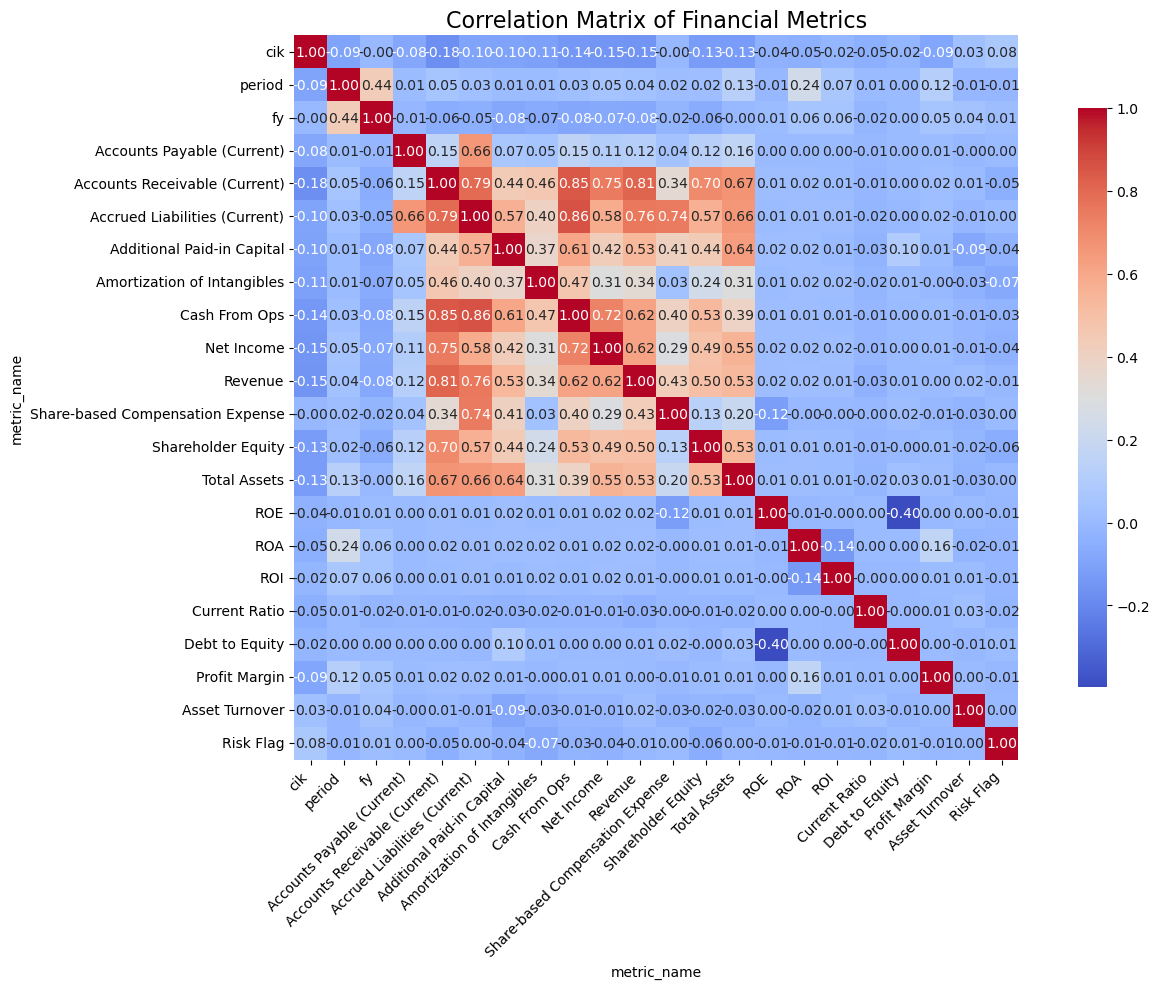

In [916]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove non-numeric columns before correlation
numeric_edf = edf.select_dtypes(include=['number', 'category'])

# Calculate correlation matrix
correlation_matrix = numeric_edf.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Financial Metrics", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Strong Correlations in Financial Metrics

| Metric A                       | Metric B                         | Correlation |
|--------------------------------|----------------------------------|-------------|
| Accounts Payable (Current)     | Accrued Liabilities (Current)    | 0.86        |
| Accounts Receivable (Current)  | Revenue                          | 0.81        |
| Cash From Ops                  | Net Income                       | 0.85        |
| Cash From Ops                  | Accrued Liabilities (Current)    | 0.86        |
| Net Income                     | Revenue                          | 0.72        |



Those correlations (r ≥ 0.80) indicate strong linear relationships. Many reflect expected financial dependencies — such as between revenue and accounts receivable, or net income and cash flow from operations.


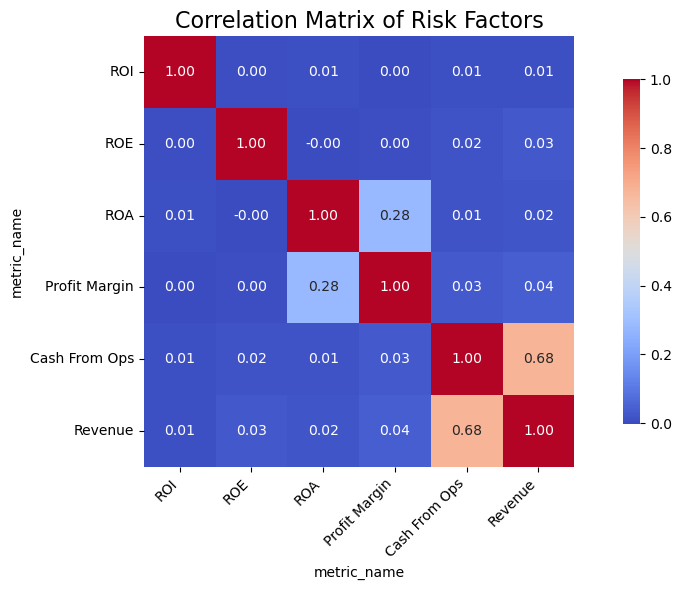

In [917]:
# Выбираем только интересующие нас метрики
risk_factors = ['ROI', 'ROE', 'ROA', 'Profit Margin', 'Cash From Ops', 'Revenue']

# Фильтруем DataFrame, оставляя только указанные метрики
filtered_edf = edf[risk_factors].dropna()

# Рассчитываем матрицу корреляций
correlation_matrix = filtered_edf.corr()

# Визуализируем матрицу корреляций
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Risk Factors", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [918]:
edf.columns

x = edf['Net Income']
y = edf['Accounts Payable (Current)']



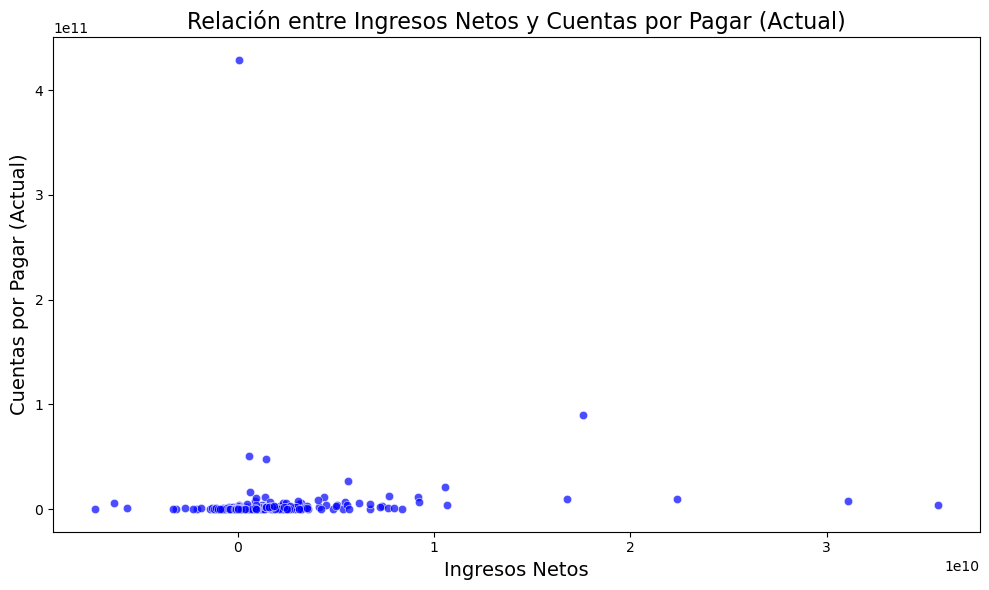

In [919]:
import seaborn as sns
import matplotlib.pyplot as plt

# Construcción del gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, color='blue', alpha=0.7)
plt.title("Relación entre Ingresos Netos y Cuentas por Pagar (Actual)", fontsize=16)
plt.xlabel("Ingresos Netos", fontsize=14)
plt.ylabel("Cuentas por Pagar (Actual)", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_984\2400630794.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


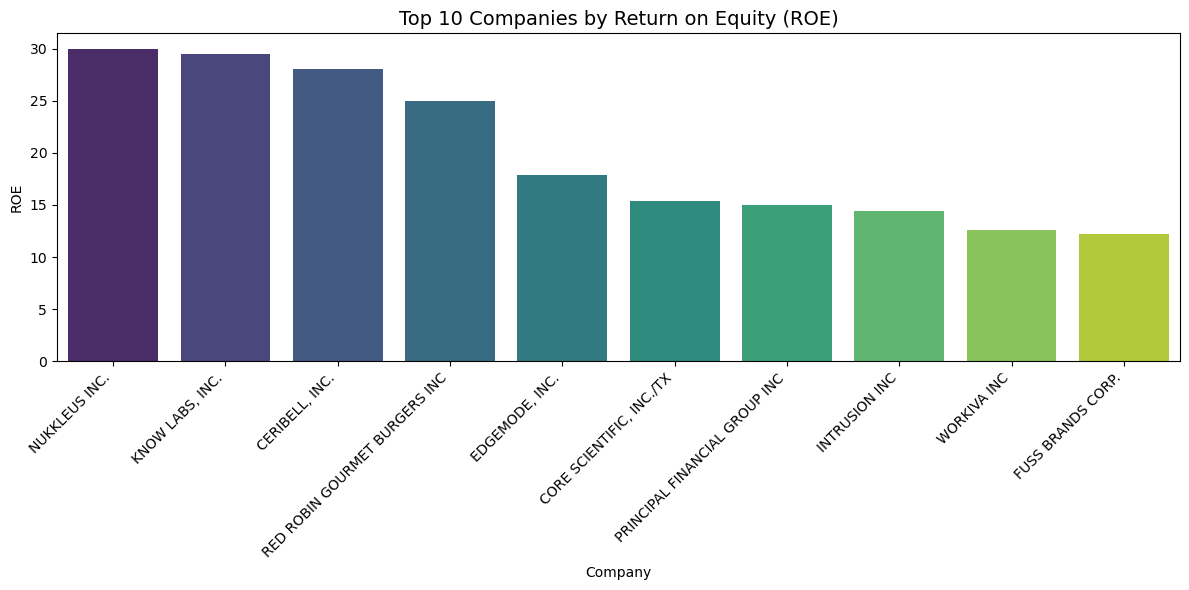

In [920]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter, drop NaNs, and select top 10 by ROE
top_10_roe = (
    edf.dropna(subset=['ROE'])
    .sort_values(by='ROE', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_984\2751412124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


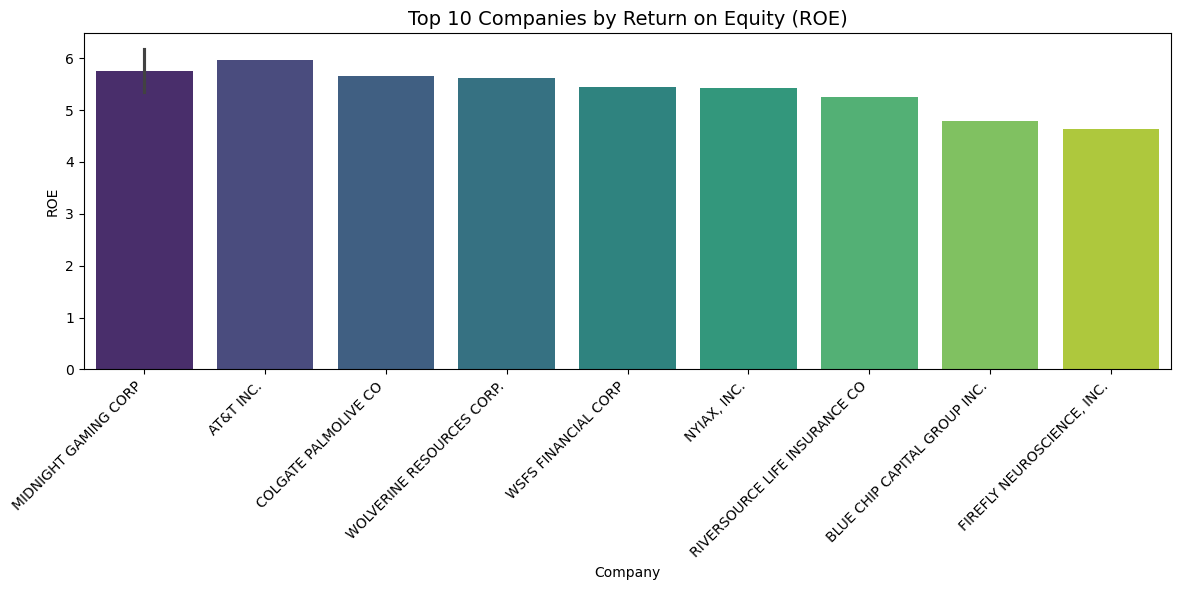

In [921]:
# --- Plot: Top 10 companies by ROE (excluding extreme outliers) ---
filtered_roe = edf.dropna(subset=['ROE'])
filtered_roe = filtered_roe[filtered_roe['ROE'] < filtered_roe['ROE'].quantile(0.99)]
top_10_roe = filtered_roe.sort_values(by='ROE', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_984\1315870465.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


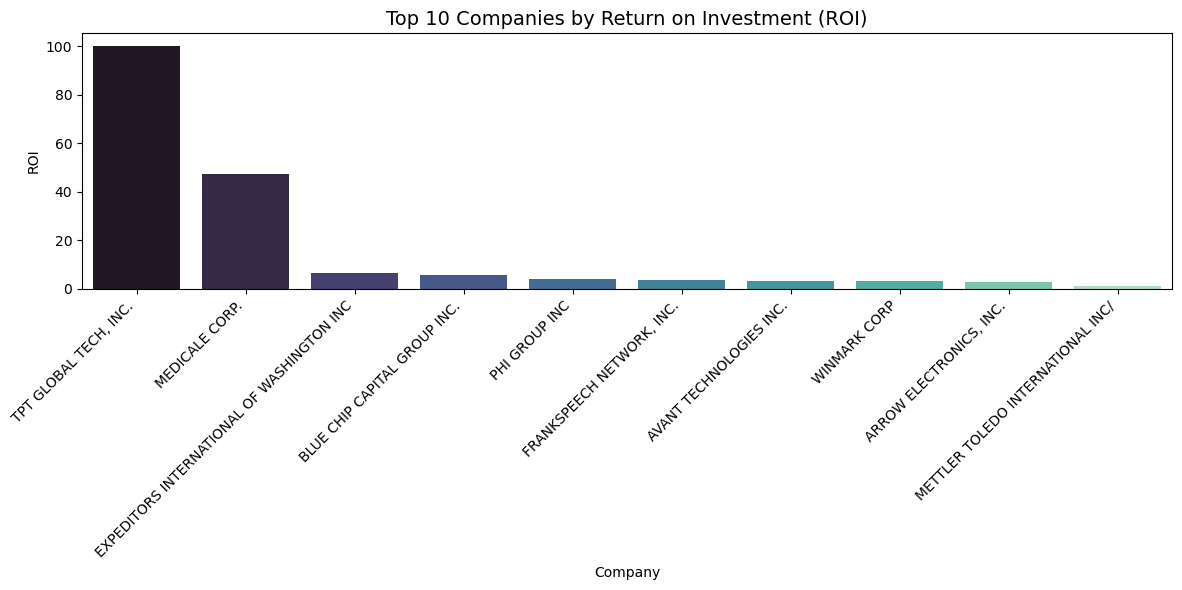

In [922]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_984\1107599803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


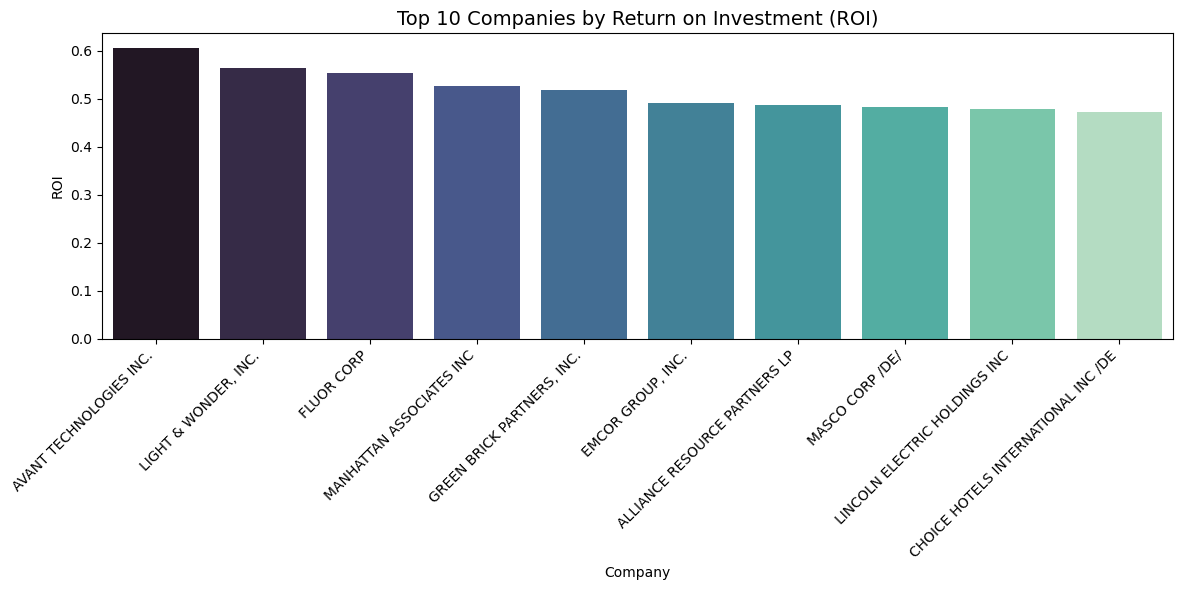

In [923]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
filtered_roi = filtered_roi[filtered_roi['ROI'] < filtered_roi['ROI'].quantile(0.99)]
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Estadística

Una vez que comprendemos la estructura básica de los datos, debemos aplicar medidas estadísticas para describir su comportamiento y distribución. Esto incluye:

##### Descriptiva
- Estadísticas de tendencia central: media, mediana, moda
- Medidas de dispersión: rango, varianza, desviación estándar, percentiles
- Distribuciones: histograma, boxplot, KDE
- Estadísticas por subgrupos (segmentación por género, edad, región, etc.)

  
##### Inferencial
- Correlaciones entre variables numéricas
- Contraste de hipótesis: por ejemplo, ¿es diferente la edad del segmento A a la del B?
- Plantear modelo de regresión lineal sobre una variable dependiente en función del resto de datos (por ejemplo  precio de vivienda en función de m2 o numero de habitaciones)
- Unos resultados no-concluyentes, no confirmatorios con la pregunta de investigación inicial o con una muestra muy pequeña son igualmente necesarios siempre que se expliciten las limitaciones. Aunque tengas pocos datos: intenta plantear igualmente estos análisis.

Estas métricas permiten detectar patrones, comportamientos anómalos, y relaciones entre variables que pueden ser clave para responder a las preguntas de investigación.

In [924]:
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting
import seaborn as sns  # Ensure seaborn is also imported for visualization

# --- Descriptive Statistics ---
print("\nBasic descriptive statistics:")

# Calculate main descriptive statistics
desc_stats = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].describe().T.copy()

# Add median and mode
desc_stats['median'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].median()
desc_stats['mode'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].mode().iloc[0]
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['variance'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].var()

# Rename columns to English
desc_stats = desc_stats.rename(columns={
    'mean': 'mean',
    'std': 'standard deviation',
    'min': 'minimum',
    '25%': '25th percentile',
    '50%': '50th percentile',
    '75%': '75th percentile',
    'max': 'maximum'
})

# Select columns to display
columns_to_display = ['mean', 'median', 'mode', 'standard deviation', 'minimum', 'maximum',
                      '25th percentile', '50th percentile', '75th percentile']

# Transpose for a readable "pivot" format
# --- a. Measures of central tendency ---
central_tendency = desc_stats[['mean', 'median', 'mode']].T
central_tendency.columns.name = "Metric"

# --- b. Measures of dispersion ---
dispersion = desc_stats[['minimum', 'maximum', 'range', 'variance', 'standard deviation',
                         '25th percentile', '50th percentile', '75th percentile']].T
dispersion.columns.name = "Metric"

print("\nMeasures of central tendency:")
print(central_tendency)

print("\nMeasures of dispersion:")
print(dispersion)


Basic descriptive statistics:

Measures of central tendency:
Metric    Net Income       Revenue       ROE       ROA
mean    4.199686e+08  2.621615e+09 -0.165010 -0.496150
median  2.942400e+07  4.669432e+08  0.079133  0.015872
mode   -8.030000e+07  0.000000e+00 -0.802623 -1.539925

Measures of dispersion:
Metric                Net Income       Revenue         ROE         ROA
minimum            -7.269333e+09 -2.280000e+08 -228.632850 -312.888000
maximum             5.415300e+10  1.122149e+11   29.981522   67.216718
range               6.142233e+10  1.124429e+11  258.614372  380.104718
variance            4.307398e+18  6.282314e+19   39.430167   77.669652
standard deviation  2.075427e+09  7.926105e+09    6.279344    8.813039
25th percentile    -5.181651e+06  6.052750e+07   -0.083617   -0.039760
50th percentile     2.942400e+07  4.669432e+08    0.079133    0.015872
75th percentile     2.405575e+08  1.984070e+09    0.289354    0.059984


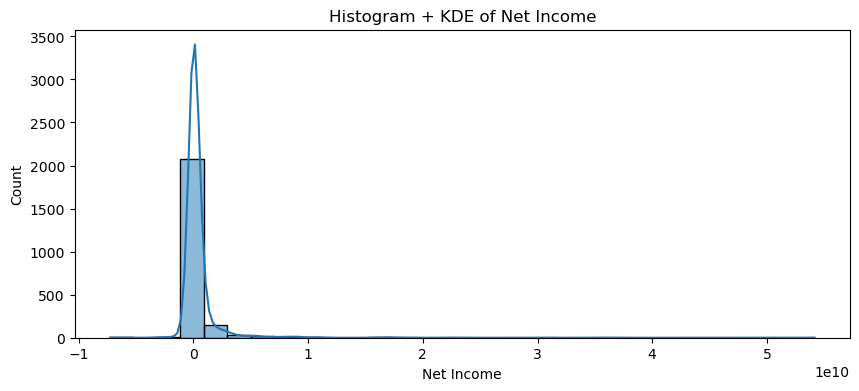

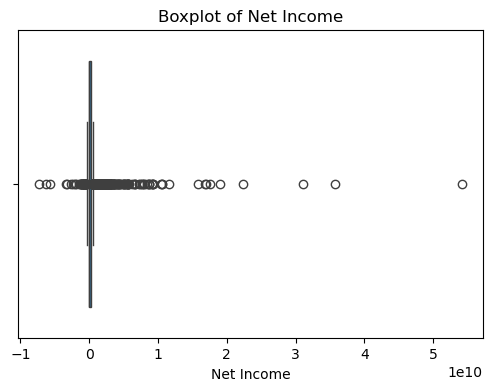

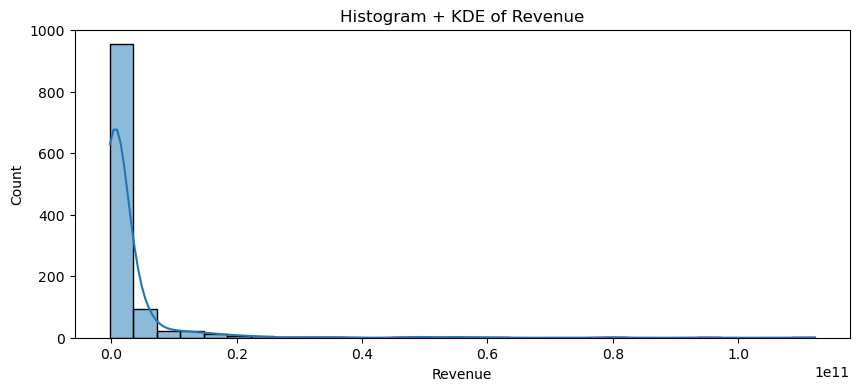

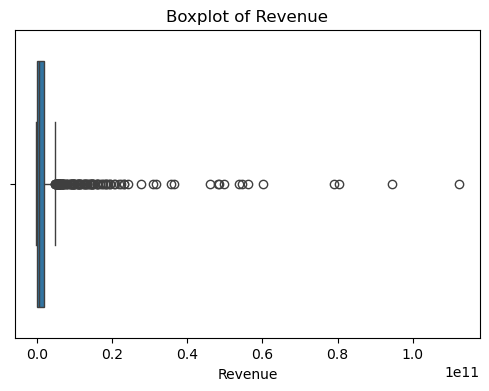

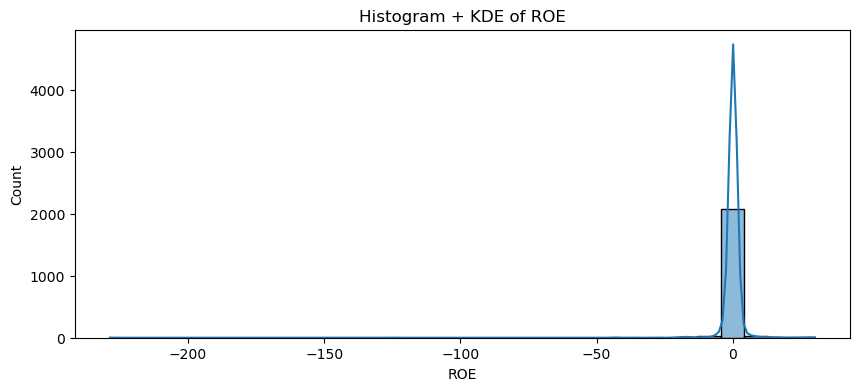

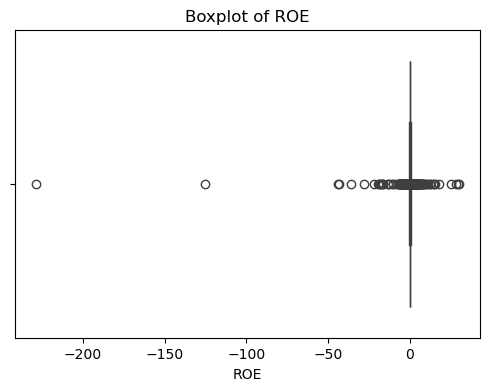

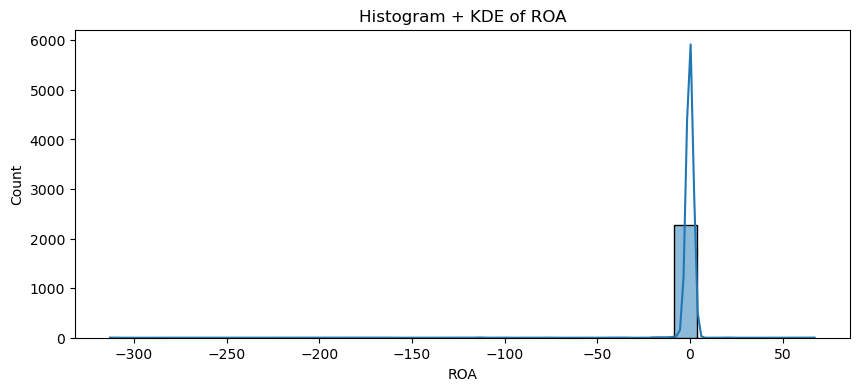

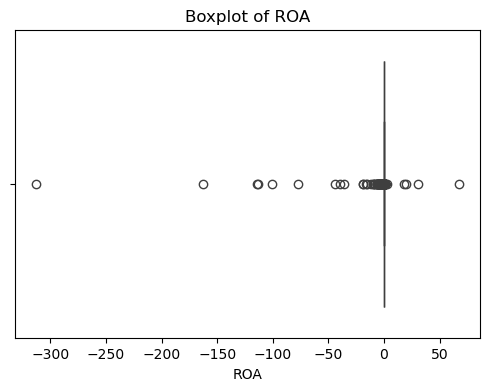


Correlations between financial metrics:
metric_name  Net Income   Revenue       ROE       ROA
metric_name                                          
Net Income     1.000000  0.615318  0.017847  0.015229
Revenue        0.615318  1.000000  0.015667  0.020338
ROE            0.017847  0.015667  1.000000 -0.007640
ROA            0.015229  0.020338 -0.007640  1.000000


In [925]:
# --- Histogram and Boxplot ---
for metric in ['Net Income', 'Revenue', 'ROE', 'ROA']:
    plt.figure(figsize=(10, 4))
    sns.histplot(edf[metric].dropna(), kde=True, bins=30)
    plt.title(f'Histogram + KDE of {metric}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=edf[metric].dropna())
    plt.title(f'Boxplot of {metric}')
    plt.show()

# --- Correlations ---
print("\nCorrelations between financial metrics:")
print(edf[['Net Income', 'Revenue', 'ROE', 'ROA']].corr())

In [926]:
# --- Hypothesis Test: Is ROA different between companies filing 10-K and 10-Q forms? ---

# Import necessary libraries
from scipy.stats import ttest_ind
from IPython.display import display, Markdown

# Filter the DataFrame to keep only records with 10-K and 10-Q forms and valid ROA values
filtered_df = edf[edf['form'].isin(['10-K', '10-Q'])].dropna(subset=['ROA'])

# Separate the data into two groups based on the type of form
roa_10k = filtered_df[filtered_df['form'] == '10-K']['ROA']
roa_10q = filtered_df[filtered_df['form'] == '10-Q']['ROA']

# Apply Welch's t-test (does not assume equal variances)
t_stat, p_value = ttest_ind(roa_10k, roa_10q, equal_var=False)

# Calculate the mean ROA for each group
mean_10k = roa_10k.mean()
mean_10q = roa_10q.mean()

# Create a Markdown table to present the results with explanations in Spanish
markdown_table = """
### Results of the t-test

| Indicator         | Value               | Interpretation |
|-------------------|---------------------|----------------|
| t-statistic       | `{:.2f}`            | t-test statistic: measures the difference between means. The larger the value, the greater the difference. |
| p-value           | `{:.2e}` (≈ `{:.7f}`) | A very low value → indicates that the difference is statistically significant (compared to 0.05 or 0.01). |
| mean_10k          | `{:.3f}`            | Average ROA for companies filing annual forms (10-K) |
| mean_10q          | `{:.3f}`            | Average ROA for companies filing quarterly forms (10-Q) |
""".format(t_stat, p_value, p_value, mean_10k, mean_10q)

# Display the table
display(Markdown(markdown_table))



### Results of the t-test

| Indicator         | Value               | Interpretation |
|-------------------|---------------------|----------------|
| t-statistic       | `1.88`            | t-test statistic: measures the difference between means. The larger the value, the greater the difference. |
| p-value           | `6.09e-02` (≈ `0.0609131`) | A very low value → indicates that the difference is statistically significant (compared to 0.05 or 0.01). |
| mean_10k          | `-0.052`            | Average ROA for companies filing annual forms (10-K) |
| mean_10q          | `-1.466`            | Average ROA for companies filing quarterly forms (10-Q) |


In [927]:
# --- Linear Regression Model ---

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

# 1. Filter the DataFrame for necessary variables and remove null values
df_model = edf[['ROI', 'Net Income', 'Revenue', 'Cash From Ops', 'Total Assets', 'Shareholder Equity', 'form', 'fp']].dropna()

# 2. Remove extreme outliers in ROI (e.g., outside the range -2 to 2)
df_model = df_model[(df_model['ROI'] > -2) & (df_model['ROI'] < 2)]

# 3. Apply logarithmic transformation to some numerical variables (use +1 to handle zeros or negatives)
for col in ['Net Income', 'Revenue', 'Cash From Ops', 'Total Assets', 'Shareholder Equity']:
    df_model[f'log_{col}'] = np.log(df_model[col].abs() + 1)

# 4. Encode categorical variables 'form' and 'fp' as dummy variables (one-hot encoding)
df_model = pd.get_dummies(df_model, columns=['form', 'fp'], drop_first=True)

# 5. Select predictor variables (all transformed + dummy variables)
X_cols = [col for col in df_model.columns if col.startswith('log_') or col.startswith('form_') or col.startswith('fp_')]
X = df_model[X_cols]
y = df_model['ROI']

# 6. Standardize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)  # Add constant

# 7. Create the linear regression model
model = sm.OLS(y, X_scaled).fit()

# 8. Extract significant variables (p < 0.05)
significant_vars = []
for i, pval in enumerate(model.pvalues):
    if pval < 0.05 and i != 0:  # i=0 is the constant
        significant_vars.append(f"x{i}")

# Map variable names to their actual column names
mapped_vars = dict(zip([f"x{i}" for i in range(1, X.shape[1] + 1)], X.columns))
significant_named = [mapped_vars[x] for x in significant_vars]

# 9. Display a structured summary of the model
markdown_summary = f"""
### Linear Regression Model Summary

| Indicator                         | Value                                  |
|----------------------------------|----------------------------------------|
| R² (coefficient of determination)  | `{model.rsquared:.3f}` → explains approximately {model.rsquared * 100:.1f}% of the variation in ROI |
| p-value of the model (F-statistic) | `{model.f_pvalue:.2e}` → the model is {"statistically significant" if model.f_pvalue < 0.05 else "not significant"} |
| Significant variables (p < 0.05)   | {", ".join(f"`{v}`" for v in significant_named) if significant_named else "None"} |
| Standardization                    | Applied (`StandardScaler`)            |
| Categorical variables (dummy)      | `form`, `fp` — converted to dummy variables |
"""

display(Markdown(markdown_summary))



### Linear Regression Model Summary

| Indicator                         | Value                                  |
|----------------------------------|----------------------------------------|
| R² (coefficient of determination)  | `0.372` → explains approximately 37.2% of the variation in ROI |
| p-value of the model (F-statistic) | `1.10e-43` → the model is statistically significant |
| Significant variables (p < 0.05)   | `log_Net Income`, `log_Revenue`, `log_Total Assets`, `form_10-K/A`, `form_10-Q/A`, `form_S-1` |
| Standardization                    | Applied (`StandardScaler`)            |
| Categorical variables (dummy)      | `form`, `fp` — converted to dummy variables |


In [928]:
# --- Non-conclusive results or results that do not confirm the initial research question 
# or are based on a very small sample are still necessary as long as the limitations are explicitly stated ---

import pandas as pd
import statsmodels.api as sm
from IPython.display import display, Markdown

# 1. Filter the data
model_data = edf.dropna(subset=['ROE', 'Net Income', 'Revenue'])
X = model_data[['Net Income', 'Revenue']]
y = model_data['ROE']
X = sm.add_constant(X)

# 2. Train the model
model = sm.OLS(y, X).fit()

# 3. Extract key metrics
r2 = model.rsquared
p_val_model = model.f_pvalue
coef_net_income = model.params['Net Income']
coef_revenue = model.params['Revenue']
pval_net_income = model.pvalues['Net Income']
pval_revenue = model.pvalues['Revenue']

# 4. Create a tabulated summary
markdown_tabla = f"""
### Linear Regression Model Summary

| Indicator                              | Value                                                         |
|----------------------------------------|---------------------------------------------------------------|
| R² (coefficient of determination)      | `{r2:.3f}` → the model {"does not " if r2 < 0.01 else ""}explain approximately {r2*100:.1f}% of the variation in ROE |
| p-value of the model (F-statistic)     | `{p_val_model:.2e}` → the model is {"statistically significant" if p_val_model < 0.05 else "not significant"} |
| Coefficient for Net Income             | `{coef_net_income:.4f}`, p = `{pval_net_income:.3f}`          |
| Coefficient for Revenue                | `{coef_revenue:.4f}`, p = `{pval_revenue:.3f}`                |
| Significant variables (p < 0.05)       | {", ".join(f"`{v}`" for v in ['Net Income', 'Revenue'] if model.pvalues[v] < 0.05) or "None"} |
"""

# 5. Display the summary
display(Markdown(markdown_tabla))



### Linear Regression Model Summary

| Indicator                              | Value                                                         |
|----------------------------------------|---------------------------------------------------------------|
| R² (coefficient of determination)      | `0.000` → the model does not explain approximately 0.0% of the variation in ROE |
| p-value of the model (F-statistic)     | `8.89e-01` → the model is not significant |
| Coefficient for Net Income             | `0.0000`, p = `0.943`          |
| Coefficient for Revenue                | `0.0000`, p = `0.736`                |
| Significant variables (p < 0.05)       | None |


The reason your regression output is filled with nan and inf is likely due to extreme values (outliers) or multicollinearity / numerical instability in the variables, especially Net Income and Revenue.

In [929]:

model_data = edf[['ROE', 'Net Income', 'Revenue']].copy()

# Remove outliers using quantiles
q_low = model_data.quantile(0.01)
q_high = model_data.quantile(0.99)
model_data = model_data[(model_data >= q_low) & (model_data <= q_high)]

# --- Replace inf/-inf and drop remaining NaNs ---
model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()

# --- Log transformation ---
model_data['log_ni'] = np.log1p(model_data['Net Income'])
model_data['log_rev'] = np.log1p(model_data['Revenue'])


c:\Users\natal\anaconda3\envs\credit-analysis-dashboard\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [930]:
import numpy as np

# Remove rows with NaN or infinite values in X or y
X = model_data[['log_ni', 'log_rev']]
y = model_data['ROE']
X = sm.add_constant(X)

# Drop rows with NaN or infinite values
mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[mask]
y = y[mask]

# Fit the model
model = sm.OLS(y, X).fit()
print("\nResumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):")
print(model.summary())



Resumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.037
Date:                Thu, 10 Apr 2025   Prob (F-statistic):             0.0181
Time:                        00:17:52   Log-Likelihood:                -750.27
No. Observations:                 638   AIC:                             1507.
Df Residuals:                     635   BIC:                             1520.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------